## CIML MNIST with regularization and tensorboard exercise

**Goal: explore regularization methods with a noisy MNIST and use tensorboard**

Adding noise makes MNIST harder so we can see effects of 
L1 regularization, DropOut, or, Batch Normalization

**Tasks:** 
<br>
1  Run the code as is, with no regularization
<br>
2  Run the code with L1 regularization  (note the default value is 0.01)
<br>   Add this option to the first dense layer
<br> $\;\;\;\;\;$        "kernel_regularizer=keras.regularizers.l1(0.01)"
<br>
3  Run tensorboard and see the effects of L1 on histograms of the weights
<br>  Open a terminal window in Jupyter Lab, find the folder with the logs, enter:
<br> $\;\;\;\;\;$ > tensorboard dev upload --logdir logs
    --name "my MNIST exercise" \
    --description " regularization test"

<br>
$\;\;\;\;\;$ Then cut & paste the URL to open tensorboard display
<br>
$\;\;\;\;\;$ Find the histogram tab (only weights are logged)
<br>
$\;\;\;\;\;$ Toggle the log data you want to see (left side)

**Advanced**
<br>
Add a dropout layer (after first dense layer), see how it affects overfitting 
    ... add(Dropout(0.50))                 #zeros out 50% of activations
<br>
Add a batch_normalization layer
    ... add(BatchNormalization(axis=-1))    #normalize activations of last dimension

## Next cell sets up directory for tensorboard logs ## 

In [1]:
#Set up the location for tensorflow logs
import datetime, os
logdir  = os.path.join("logs", 
                datetime.datetime.now().strftime("%Y%m%d-%H%M%S")+'_'+ \
                       'test')   #<<<<<----- you can add a comment to describe the test
print('using',logdir,' for logs')

using logs/20210726-183819_test  for logs


In [2]:
# ----------- IMPORT STATEMENTS ---------------
import numpy as np
np.random.seed(1)  # for reproducibility
 
from tensorflow import keras

from tensorflow.keras.models import Sequential               #Sequential models are the standard stack of layers models
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout, Activation, Flatten   #These are core layer specification functions
from tensorflow.keras.layers import Convolution2D, MaxPooling2D      #These are convolution layer functions
from tensorflow.keras import optimizers                             #For training algorithm

# Load the TensorBoard notebook extension
#%load_ext tensorboard

import tensorflow as tf
#---------------------------------------------
print('import done')

import done


In [4]:
#Load MNIST data from Keras datasets
(X_train, Y_train), (X_test, Y_test) = tf.keras.datasets.mnist.load_data()

print('data loaded:'+str(X_train.shape))

data loaded:(60000, 28, 28)


## Next cell switches some labels as noise, and only uses first 200 samples for training, to make the task harder to learn ##

In [5]:
#Set up subset of full dataset for training, switch some targets
numsamps2use       = 200
num_target_2switch = 45
X_train = X_train[0:numsamps2use,]  #only need smaller subset to get good results
Y_train = Y_train[0:numsamps2use,]

#now switch some target values
for i in range(num_target_2switch):
    inds_2switch = np.random.choice(np.arange(numsamps2use),2)
    temp_targ                = Y_train[inds_2switch[1]]
    Y_train[inds_2switch[1]] = Y_train[inds_2switch[0]]
    Y_train[inds_2switch[0]] = temp_targ

print('img load done, targets switched')


img load done, targets switched


In [6]:
# --------- Reshape input data ------------
#  b/c Keras expects N-3D images (ie 4D matrix)
#np.expand_dims(X_train[i], 0)
X_train = X_train[:,:,:,np.newaxis]
X_test  = X_test[:,:,:,np.newaxis]

print('added dimension')

added dimension


In [7]:
#convert and put into 0-1 range
X_train  = X_train.astype('float32')
X_test   = X_test.astype('float32')

#Scale 0 to 1  - or should we not scale
X_train /= 255
X_test  /= 255

# Convert 1-dimensional class arrays to 10-dimensional class matrices
Y_train = keras.utils.to_categorical(Y_train, 10)
Y_test  = keras.utils.to_categorical(Y_test,  10)

# ------------- End loading and preparing data --------------
xtmax = np.amax(X_train)   #this gets the max value over a flattened numpy array
print('prep done, max value in images: '+str(xtmax))


prep done, max value in images: 1.0


## Next cells set up model and run fit, then plot performance ##

In [8]:
# --------------Set up Model ---------------------
mymodel = keras.models.Sequential()

numfilters = 64  
mymodel.add(Convolution2D(numfilters, (3,3), strides=1,  data_format="channels_last", activation='relu', input_shape=(28,28,1))) 
mymodel.add(Convolution2D(numfilters, (3,3), strides=1,  data_format="channels_last", activation='relu'))
mymodel.add(MaxPooling2D(pool_size=(2,2),strides=2,data_format="channels_last")) 
mymodel.add(Flatten())         

#----- add final classification layers
mymodel.add(Dense(64, activation='relu',kernel_regularizer=keras.regularizers.l1(0.01)))  
                                            #<<<<---- Add the L1 reglzer option here  
                                            #<<<<-----optionally add dropout or normalization here
                                            #<<<<----- as in add(Dropout(0.50)) or add(BatchNormilzation(axis=-1))
mymodel.add(Dense(10, activation='softmax'))

print('added layers to model')

added layers to model


In [9]:
# --------- Now assemble (ie compile TensorFlow commands) and run -----
mymodel.compile(loss='categorical_crossentropy',
               optimizer='adam',
               metrics=['accuracy'])
print('compiled')
mymodel.summary()


compiled
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 64)        640       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 64)        36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 9216)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                589888    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                650       
Total params: 628,106
Trainable params: 628,106
Non-trainable params: 0
_________________________________________

In [10]:
from tensorflow.keras.callbacks import EarlyStopping
my_ES_function = EarlyStopping(monitor='val_loss', mode='min',  patience=20)

my_tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1,
                                                        profile_batch="5,10")
       #Use profile_batch to get performance info for some iterations
    
fit_history=mymodel.fit(X_train, Y_train, #validation_split=0.20,
          validation_data=(X_test,Y_test),
          batch_size=64, epochs=100, verbose=1,callbacks=[my_ES_function,my_tensorboard_callback])

Epoch 1/100
4/4 [==============================] - 1s 263ms/step - loss: 71.3206 - accuracy: 0.1250 - val_loss: 56.1686 - val_accuracy: 0.2736
Epoch 2/100
4/4 [==============================] - 1s 280ms/step - loss: 51.2775 - accuracy: 0.2600 - val_loss: 39.1504 - val_accuracy: 0.1924
Epoch 3/100
1/4 [======>.......................] - ETA: 0s - loss: 39.1297 - accuracy: 0.2812WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
4/4 [==============================] - 1s 292ms/step - loss: 35.3392 - accuracy: 0.2300 - val_loss: 26.0260 - val_accuracy: 0.3307
Epoch 4/100
4/4 [==============================] - 1s 208ms/step - loss: 23.2297 - accuracy: 0.2900 - val_loss: 16.6620 - val_accuracy: 0.3911
Epoch 5/100
4/4 [==============================] - 1s 201ms/step - lo

In [11]:
#

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


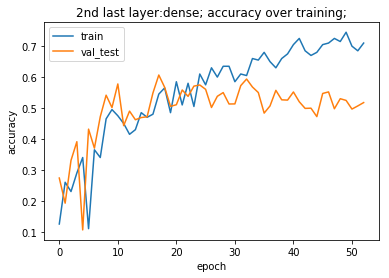

In [12]:
# Plot the fit history
import matplotlib.pyplot as plt     
import matplotlib.image as mpimg
%matplotlib inline                   

# list data fields that are available in history
print(fit_history.history.keys())

# summarize history for accuracy
metric2plot='accuracy'
plt.figure()
plt.plot(fit_history.history[metric2plot])
plt.plot(fit_history.history['val_'+metric2plot])
plt.title('2nd last layer:'+mymodel.layers[-2].name+'; '+metric2plot+' over training;')
plt.ylabel(metric2plot)
plt.xlabel('epoch')
plt.legend(['train', 'val_test'], loc='upper left')
plt.show()

In [12]:
#plt.savefig('mytest_1.png')  # if you want to save a plot

In [ ]:
#============================================================

 --------- run in a terminal ----------------
tensorboard --logdir logs --host 10.21.3.31 --port 4280 &
curl 'https://manage.expanse-user-content.sdsc.edu/redeemtoken.cgi?token=rippling-exemption-level&port=4280'
 --------- load this URL into your browswer----------------
https://rippling-exemption-level.expanse-user-content.sdsc.edu


In [21]:
#===============================


SyntaxError: invalid syntax (<string>, line 1)